# Setup environment (libraries and packages)

In [ ]:
#Builds 'n Installs
#!pip install scipy==1.2
!pip install -q --upgrade scipy;
!pip install -q --upgrade quandl;
!pip install -q --upgrade pandas-datareader;
!pip install -q --upgrade statsmodels;

     |████████████████████████████████| 25.9MB 5.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 9.5MB 6.2MB/s 


In [ ]:
from statsmodels.tsa.stattools import adfuller
import requests
import warnings
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
import io
import scipy
import quandl
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import data, wb
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick
import datetime
from datetime import date
from dateutil.parser import parse
pd.options.display.float_format = '{:.2f}'.format
plt.rcParams["figure.figsize"] = (16,12)
plt.style.use('seaborn-white')
#PARAMETERS
#drive.mount('/content/drive')
start_date = "1994-01-01"
end_date = ""
#end_date = "2011-01-01"
if end_date == "":
  end_date = datetime.datetime.now()

import matplotlib.dates as mdates

def shade_recessions():
  if start_date < "2007-01-01":
    ax.axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
  if start_date < "2001-01-01":
    ax.axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
  if start_date < "1990-01-01":
    ax.axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil Price Shock")
  if start_date < "1981-01-01":
    ax.axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1980's Recession ("Reagan")
   
def plot_grid():
  ax.grid(color='lightgray', linestyle='-', linewidth=.5)

In [ ]:
#References:
#https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

# Motivating Example - Child Birth Time Series Components

In [ ]:
# Load Dataset
DATA_URL="http://robjhyndman.com/tsdldata/data/nybirths.dat"
fopen = requests.get(DATA_URL).content
ds=pd.read_csv(io.StringIO(fopen.decode('utf-8')),  header=None, names=['birthcount'])
print(ds.head())

   birthcount
0       26.66
1       23.60
2       26.93
3       24.74
4       25.81


In [ ]:
# Add time index
date=pd.date_range("1946-01-01", "1959-12-31", freq="1M")
ds['Date']=pd.DataFrame(date)
ds = ds.set_index('Date')

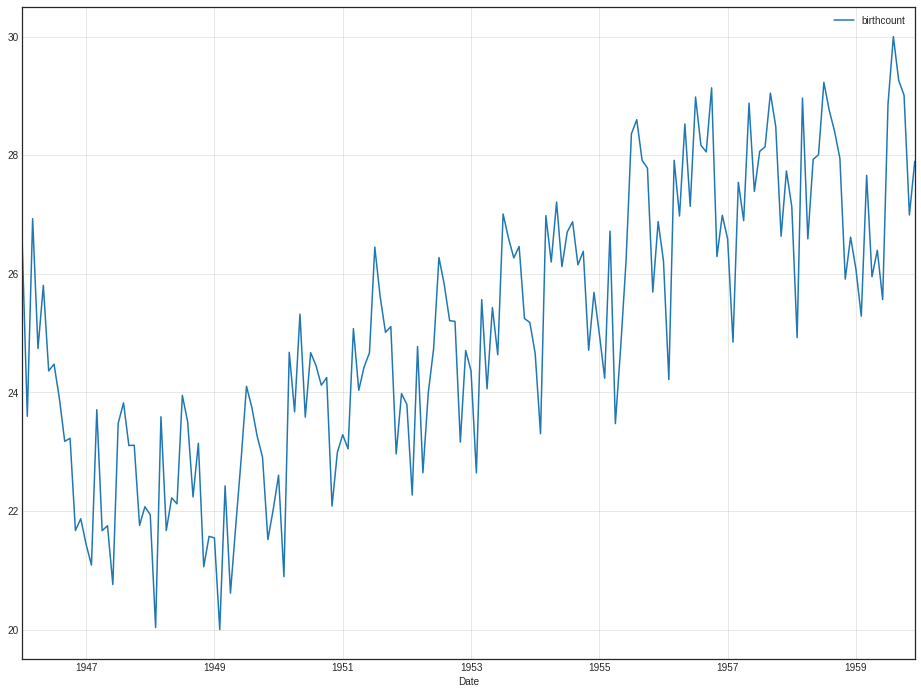

In [ ]:
ax = ds.plot(figsize=(16,12))
plot_grid()

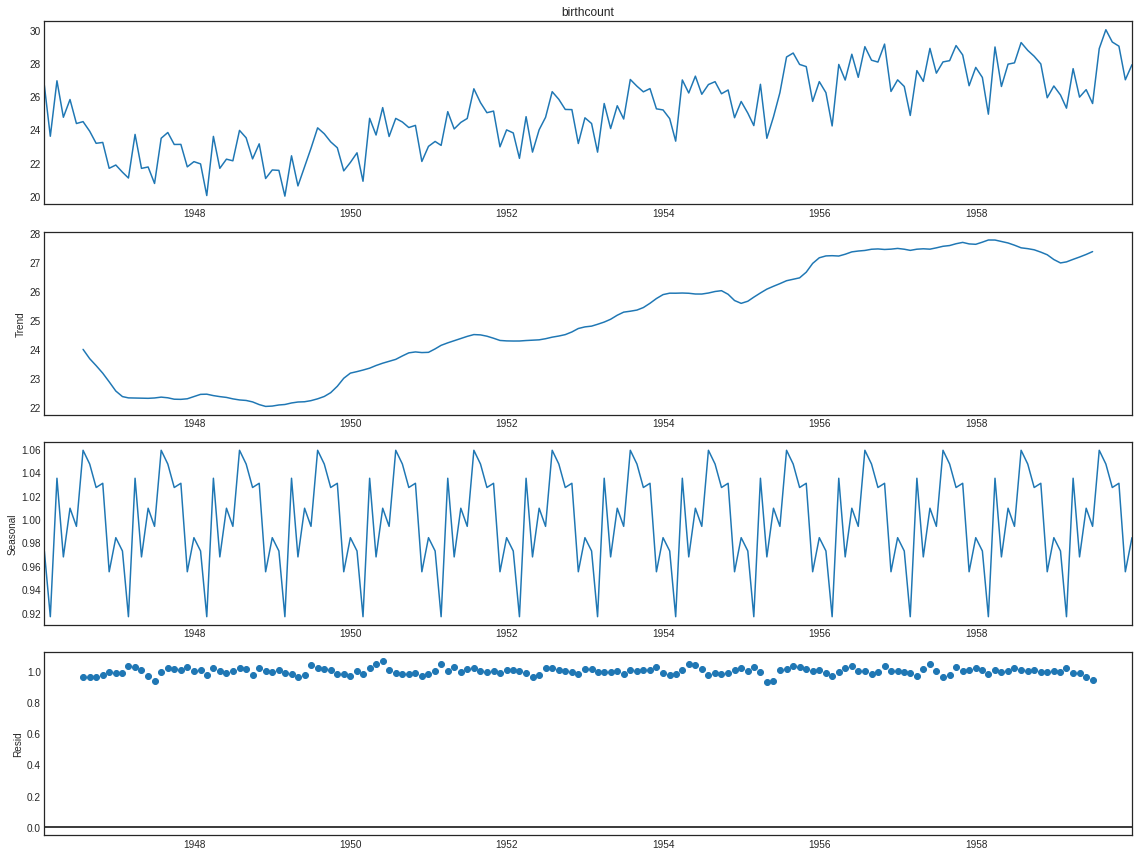

In [ ]:
# decompose dataset
res = sm.tsa.seasonal_decompose(ds.birthcount, model="multiplicative")
resplot = res.plot()

# In-Class Exercise: Obtain C02 Data Set and Decompose It

In [ ]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3
#The code below is borrowed from the site above

In [ ]:
#Acquire data (weekly values)
data = sm.datasets.co2.load_pandas()
co2 = data.data
print(co2.tail(10))

              co2
2001-10-27 368.70
2001-11-03 368.70
2001-11-10 368.80
2001-11-17 369.70
2001-11-24 370.30
2001-12-01 370.30
2001-12-08 370.80
2001-12-15 371.20
2001-12-22 371.30
2001-12-29 371.50


#Stop Here

In [ ]:
#ARIMA Time Series Model
#Auto
#Regressive
#Integrated
#Moving
#Average

#p is the auto-regressive part of the model.
#It allows us to incorporate the effect of past values into our model.
#Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

#d is the integrated part of the model.
#This includes terms in the model that incorporate the amount of differencing
#(i.e. the number of past time points to subtract from the current value) to apply to the time series.
#Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if
#the difference in temperature in the last three days has been very small.

#q is the moving average part of the model.
#This allows us to set the error of our model as a linear combination of the error values
#observed at previous time points in the past.


In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
model_output = pd.DataFrame(columns = ['parameters', 'results.aic'])

a = "bob"
b = "bob"
c = 1.0

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            #Only for diagnostic measures
            #print('ARIMA{}x{}12 - AIC:{}'.format(param,
                                                  #param_seasonal, results.aic))
            a = param
            b = param_seasonal
            c = results.aic
            model_output = model_output.append({'parameters': 'ARIMA{}x{}12'.format(a, b),
                                                'results.aic': c}, ignore_index = True)
        except:
            continue

In [ ]:
model_output.sort_values(by = 'results.aic').head(5)

,parameters,results.aic
63,"ARIMA(1, 1, 1)x(1, 1, 1, 12)12",277.78
31,"ARIMA(0, 1, 1)x(1, 1, 1, 12)12",281.52
47,"ARIMA(1, 0, 1)x(1, 1, 1, 12)12",284.36
55,"ARIMA(1, 1, 0)x(1, 1, 1, 12)12",293.74
59,"ARIMA(1, 1, 1)x(0, 1, 1, 12)12",295.94


In [ ]:
#Fit the model with the lowest AIC above

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3181      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.168      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8768      0.026    -33.802      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.634      0.000       0.089       0.106


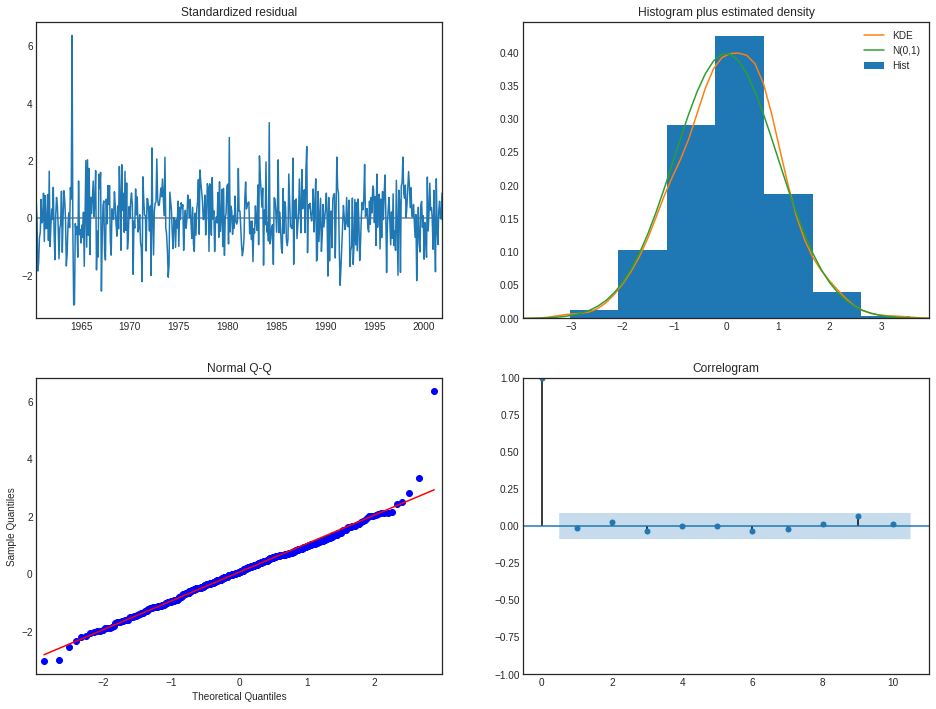

In [ ]:
results.plot_diagnostics()
plt.show()
#Top left: Gaussian Noise
#Top right: KDE closely follows a normal distribution with a mean of 0 and an SD of 1-----N(0,1)
#Bottom left: Normal-looking Q-Q plot (i.e., data points follow the red line)
#Bottom right: 

In [ ]:
#Validation - not dynamic 
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

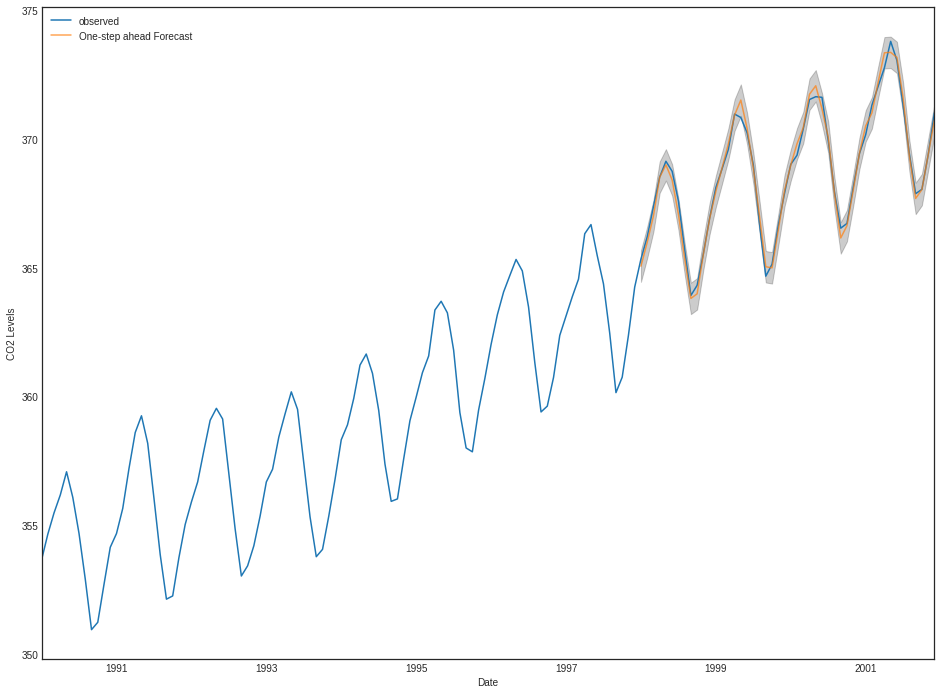

In [ ]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

In [ ]:
#Performance Criteria
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


In [ ]:
#Validation using dynamic forecast
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


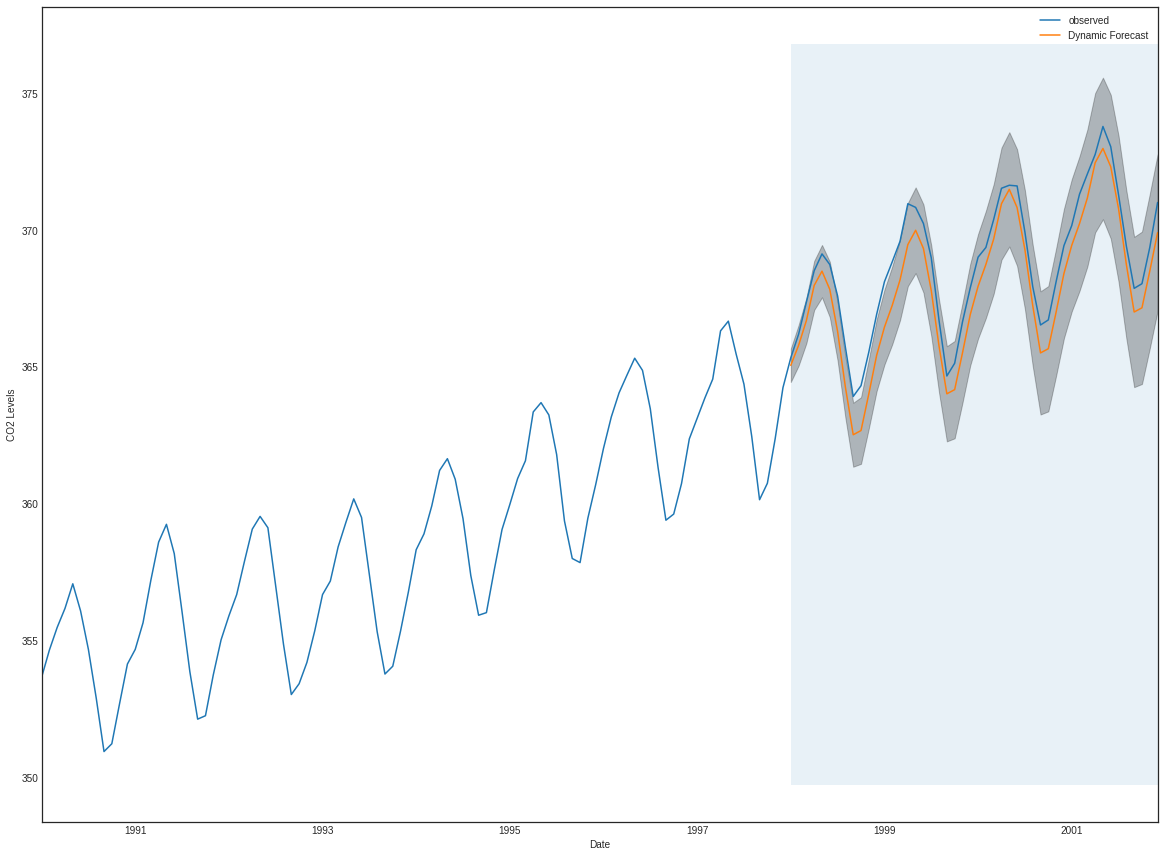

In [ ]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()

In [ ]:
#Performance Criteria
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


In [ ]:
#Prepare for a forecast

# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

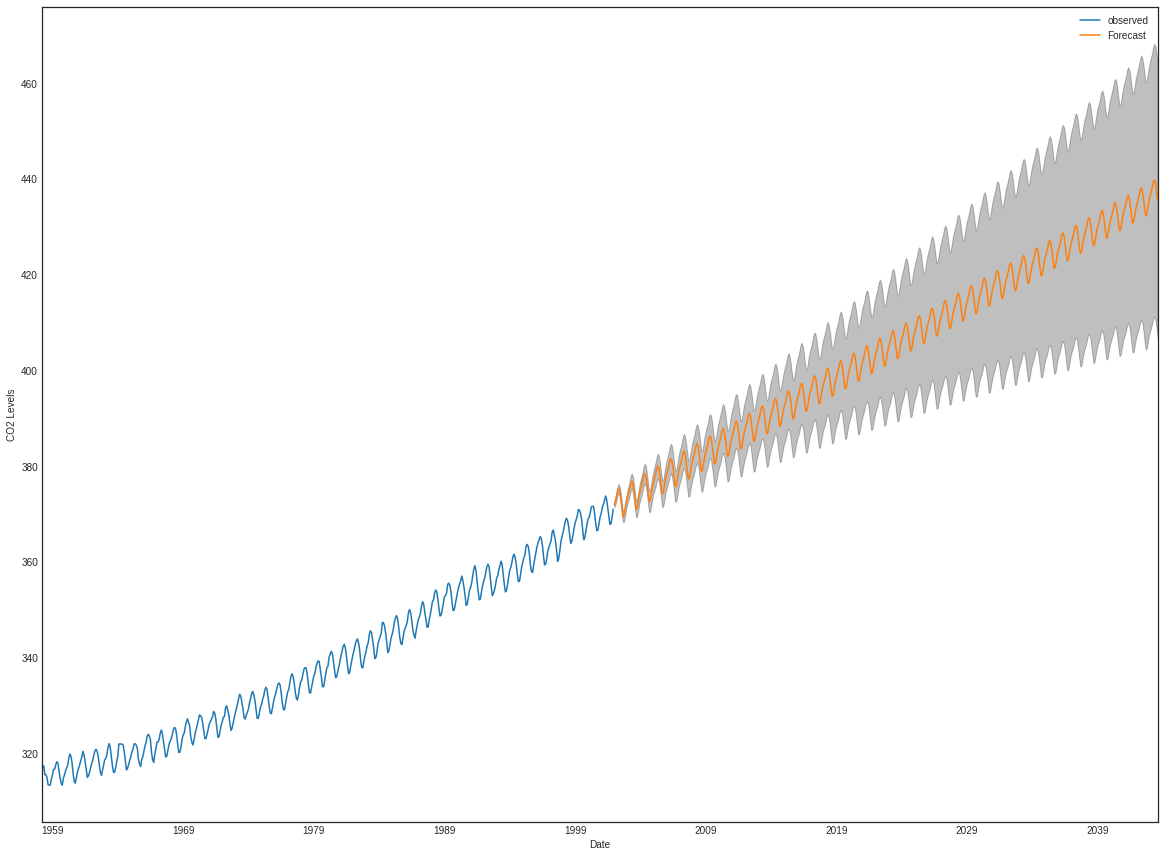

In [ ]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()

In [ ]:
#Other references:
#https://www.kaggle.com/poiupoiu/how-to-use-sarimax

# Simple Averages and Simple Moving Averages

# Augmented Dickey-Fuller Test

In [ ]:
spy_data_temp = pdr.DataReader('SPY', 'yahoo', start_date, end_date)
spy_data_temp = spy_data_temp['Adj Close']
spy_data_daily_temp = pd.DataFrame(spy_data_temp)
spy_data_daily_temp.columns = ['data']
spy_data_monthly_temp = spy_data_daily_temp.resample('M').last()

In [ ]:
df = spy_data_monthly_temp.copy()
df['z_data'] = (df['data'] - df.data.rolling(window=12).mean()) / df.data.rolling(window=12).std()
df['zp_data'] = df['z_data'] - df['z_data'].shift(12)

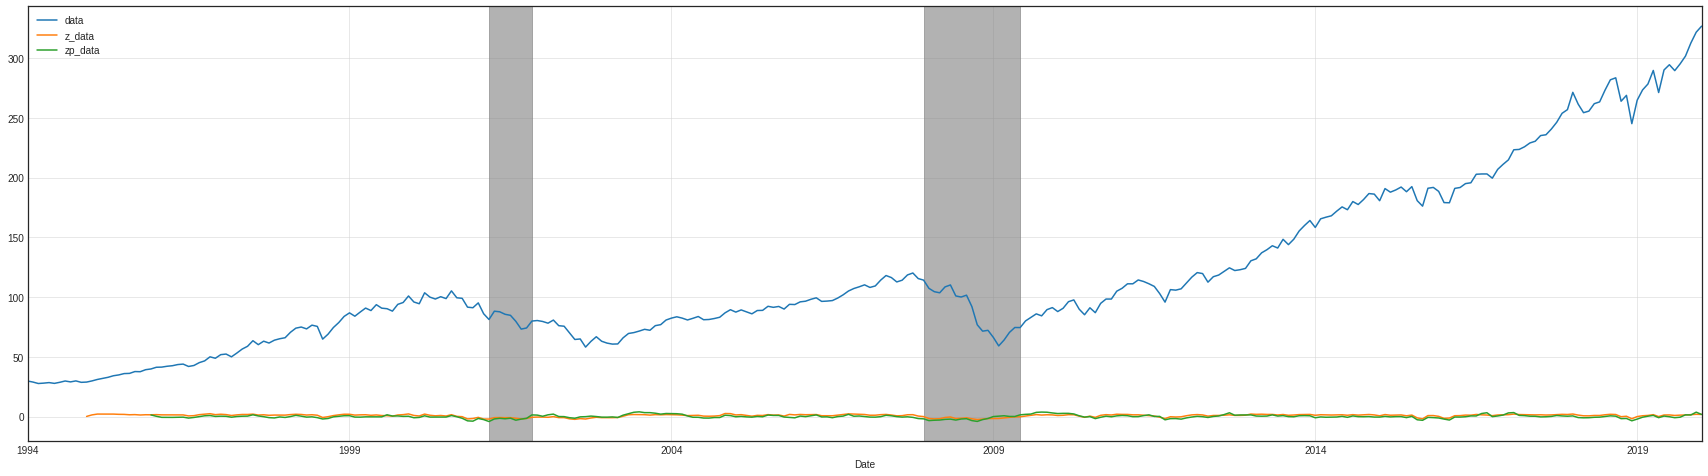

In [ ]:
ax = df.plot(figsize=(30,8))
plot_grid()
shade_recessions();

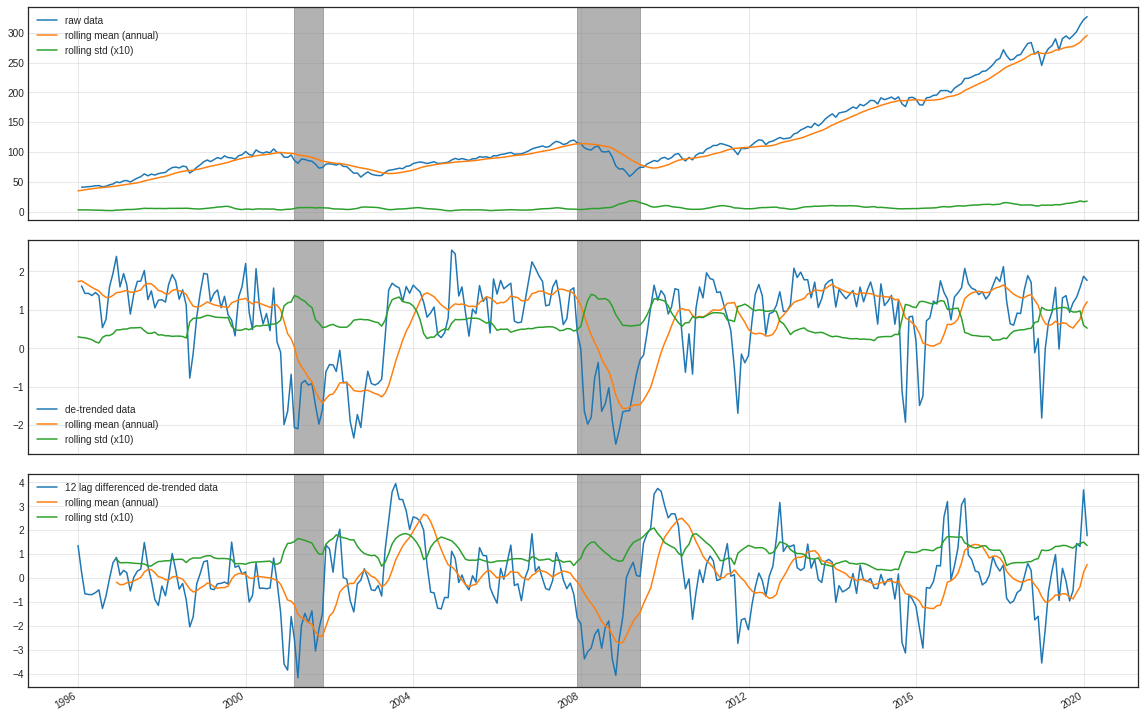

In [ ]:
def plot_rolling(df):
    fig, ax = plt.subplots(3,figsize=(16, 12))
    ax[0].plot(df[24:].index, df[24:].data, label='raw data')
    ax[0].plot(df[12:].data.rolling(window=12).mean(), label="rolling mean (annual)");
    ax[0].plot(df[12:].data.rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend(loc='upper left')

    ax[1].plot(df[24:].index, df.z_data[24:], label="de-trended data")
    ax[1].plot(df[12:].z_data.rolling(window=12).mean(), label="rolling mean (annual)");
    ax[1].plot(df[12:].z_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend(loc='lower left')

    ax[2].plot(df[23:].index, df[23:].zp_data, label="12 lag differenced de-trended data")
    ax[2].plot(df[12:].zp_data.rolling(window=12).mean(), label="rolling mean (annual)");
    ax[2].plot(df[12:].zp_data.rolling(window=12).std(), label="rolling std (x10)");
    ax[2].legend(loc='upper left')

    plt.tight_layout()
    fig.autofmt_xdate()
    if start_date < "2007-01-01":
      ax[0].axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
      ax[1].axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
      ax[2].axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
    if start_date < "2001-01-01":
      ax[0].axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
      ax[1].axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
      ax[2].axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
    if start_date < "1990-01-01":
      ax[0].axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil")
      ax[1].axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil")
      ax[2].axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil")
    if start_date < "1981-01-01":
      ax[0].axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1990's Recession ("Oil")
      ax[1].axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1990's Recession ("Oil")
      ax[2].axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1990's Recession ("Oil") 
    ax[0].grid(color='lightgray', linestyle='-', linewidth=.5)
    ax[1].grid(color='lightgray', linestyle='-', linewidth=.5)
    ax[2].grid(color='lightgray', linestyle='-', linewidth=.5)
plot_rolling(df)

In [ ]:
print(" > Is the data stationary ?")
dftest = adfuller(df.data, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data {} stationary with {}% confidence".format(k, v, "is not" if v<dftest[0] else "is", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df.z_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data {} stationary with {}% confidence".format(k, v, "is not" if v<dftest[0] else "is", 100-int(k[:-1])))
    
print("\n > Is the 12-lag differenced de-trended data stationary ?")
dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data {} stationary with {}% confidence".format(k, v, "is not" if v<dftest[0] else "is", 100-int(k[:-1])))

#I.e., is the test statistic less than the critical value?  If so, the data is stationary, if not it isn't.

 > Is the data stationary ?
Test statistic = 2.079
P-value = 0.999
Critical values :
	1%: -3.452045317832011 - The data is not stationary with 99% confidence
	5%: -2.871094805558846 - The data is not stationary with 95% confidence
	10%: -2.571860921485457 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.288
P-value = 0.000
Critical values :
	1%: -3.452263435801039 - The data is stationary with 99% confidence
	5%: -2.871190526189069 - The data is stationary with 95% confidence
	10%: -2.571911967527952 - The data is stationary with 90% confidence

 > Is the 12-lag differenced de-trended data stationary ?
Test statistic = -4.119
P-value = 0.001
Critical values :
	1%: -3.4541800885158525 - The data is stationary with 99% confidence
	5%: -2.872031361137725 - The data is stationary with 95% confidence
	10%: -2.5723603999791473 - The data is stationary with 90% confidence


#ARIMA

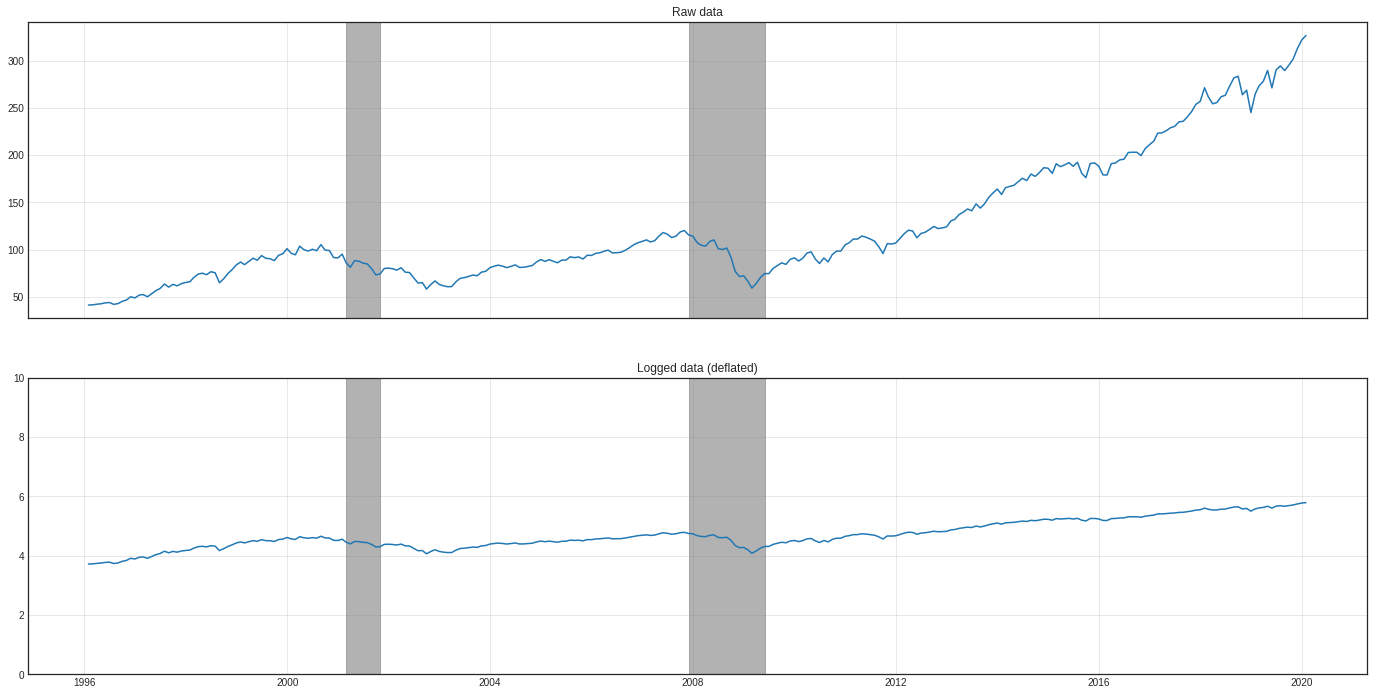

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(24,12))
#ax[0].plot(df.data.values);
ax[0].set_title("Raw data");
#ax[1].plot(np.log(df.data.values));
ax[1].set_title("Logged data (deflated)");


ax[0].plot(df[24:].index, df[24:].data, label='raw data')
ax[1].plot(df[24:].index, np.log(df[24:].data), label='raw data')
ax[1].set_ylim(0, 10);

if start_date < "2007-01-01":
  ax[0].axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
  ax[1].axvspan("2007-12", "2009-06", alpha=0.6, color='gray') #Great Recession ("Financial Crisis")
if start_date < "2001-01-01":
  ax[0].axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
  ax[1].axvspan("2001-03", "2001-11", alpha=0.6, color='gray') #Early 2000's Recession ("Dot Com Bubble")
if start_date < "1990-01-01":
  ax[0].axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil")
  ax[1].axvspan("1990-07", "1991-03", alpha=0.7, color='gray') #Early 1990's Recession ("Oil")
if start_date < "1981-01-01":
  ax[0].axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1980's Recession ("Reagan")
  ax[1].axvspan("1981-07", "1982-11", alpha=0.6, color='gray') #Early 1980's Recession ("Reagan")
ax[0].grid(color='lightgray', linestyle='-', linewidth=.5)
ax[1].grid(color='lightgray', linestyle='-', linewidth=.5)


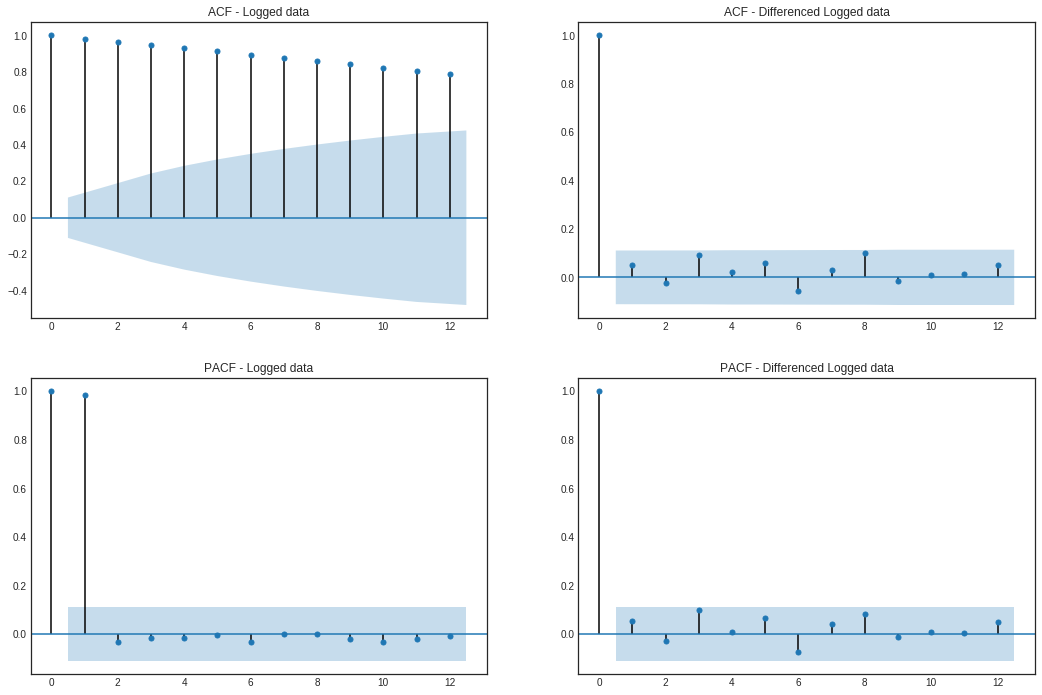

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(18,12))
first_diff = (np.log(df.data)- np.log(df.data).shift()).dropna()
ax[0, 0] = plot_acf(np.log(df.data), ax=ax[0, 0], lags=12, title="ACF - Logged data")
ax[1, 0] = plot_pacf(np.log(df.data), ax=ax[1, 0], lags=12, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=12, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=12, title="PACF - Differenced Logged data")

In [ ]:
#A seasonal ARIMA model is classified as an ARIMA(p,d,q)x(P,D,Q) model, where P=number of seasonal autoregressive (SAR) terms, D=number of seasonal differences, Q=number of seasonal moving average (SMA) terms

model = ARIMA(np.log(df.data).dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(np.log(df.data).dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

                              ARMA Model Results                              
Dep. Variable:                   data   No. Observations:                  313
Model:                     ARMA(0, 0)   Log Likelihood                -269.580
Method:                           css   S.D. of innovations              0.573
Date:                Wed, 29 Jan 2020   AIC                            543.160
Time:                        04:30:33   BIC                            550.653
Sample:                    01-31-1994   HQIC                           546.154
                         - 01-31-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6026      0.032    142.220      0.000       4.539       4.666
                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observat

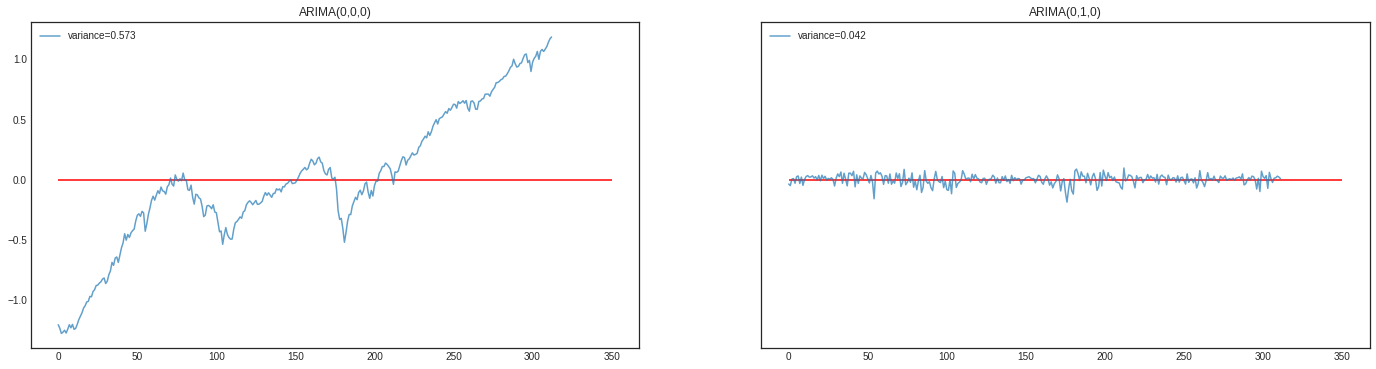

In [ ]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(24, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=350, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend(loc='upper left');

ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=350, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend(loc='upper left');

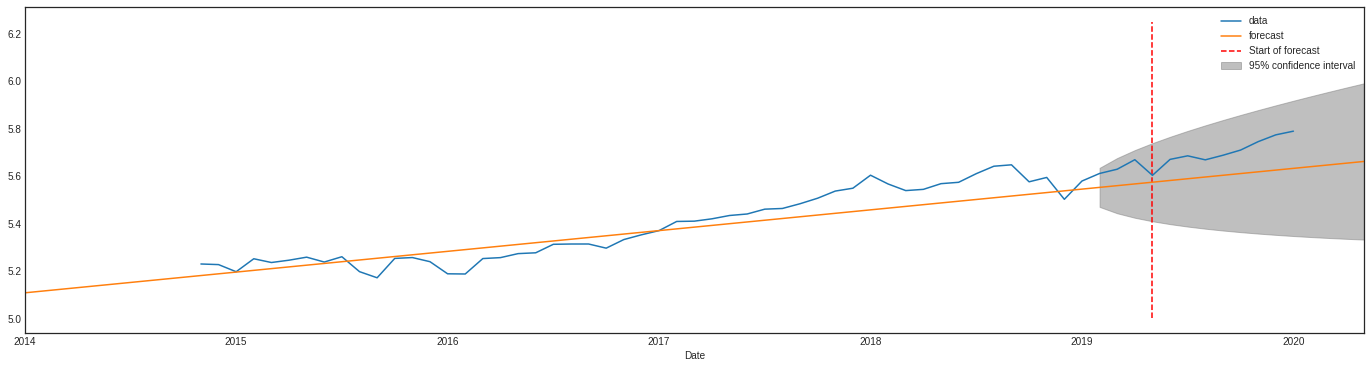

In [ ]:
model = ARIMA(np.log(df.data).dropna()[:-12], (0, 1, 0))
res_010 = model.fit()

fig, ax = plt.subplots(figsize=(24, 6));
df.index = pd.to_datetime(df.index, format="%Y-%m");
np.log(df.data).dropna()[250:].plot(ax=ax);
ax.vlines('2019-05-31', 5, 6.25, linestyle='--', color='r', label='Start of forecast');
res_010.plot_predict(start = '2014-01-31', end = '2020-05-31', dynamic = True, plot_insample=False, ax=ax);
#ax.set_xlim(pd.Timestamp('2015-01-31'), pd.Timestamp('2020-05-31'));